### 데이터 다운로드, 랜덤시드 설정

In [1]:
import pandas as pd
import numpy as np
import torch
random_seed = 123
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)

df_1 = pd.read_csv('../data/normal_vec.csv', header=None)
df_2 = pd.read_csv('../data/abnormal_vec.csv', header=None)
df_3 = pd.read_csv('../data/error_vec.csv', header=None)

In [2]:
len(df_1)

15

### normal, abnormal, error 인스턴스 생성

In [3]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
def normal_make_instance(df):
    scaler = StandardScaler()
    noise = np.random.normal(0, 7, (15,6))
    list_scaled = scaler.fit_transform(df + noise)
    abc = np.concatenate((np.array([[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]]),list_scaled,np.array([[0,0,0,0,0,0],[0,0,0,0,0,0]])))
    b = torch.from_numpy(abc)
    instance = [b, 0]
    return instance

def abnormal_make_instance(df):
    scaler = StandardScaler()
    noise = np.random.normal(0, 7, (19,6))
    list_scaled = scaler.fit_transform(df + noise)
    abc = np.concatenate((list_scaled, np.array([[0,0,0,0,0,0]])))
    b = torch.from_numpy(abc) 
    instance = [b, 2]
    return instance

def error_make_instance(df):
    scaler = StandardScaler()
    noise = np.random.normal(0, 7, (20,6))
    list_scaled = scaler.fit_transform(df + noise)
    b = torch.from_numpy(list_scaled)
    instance = [b, 1]
    return instance

### train/val/test 데이터셋 생성
### 각각 18000/6000/6000개 인스턴스 포함

In [4]:
def make_ds(df_nor, df_ab, df_er, num):
    dataset = []
    for i in range(num):
        dataset.append(normal_make_instance(df_nor))
        dataset.append(abnormal_make_instance(df_ab))
        dataset.append(error_make_instance(df_er))
        
    return dataset

In [5]:
total_dataset = make_ds(df_1, df_2, df_3, 10000)

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Subset

sss = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = random_seed)
indices = list(range(len(total_dataset)))
y_ds = [y for _, y in total_dataset]

for train_index, test_index in sss.split(indices, y_ds):
    print('train:', train_index, 'test:', test_index)
    print(len(train_index), len(test_index))

sub_train = Subset(total_dataset, train_index)
test_ds = Subset(total_dataset, test_index)

sss2 = StratifiedShuffleSplit(n_splits = 1, test_size = 0.25, random_state = random_seed)
indices2 = list(range(len(sub_train)))
y_ds2 = [y for _, y in sub_train]

for train_index2, val_index in sss2.split(indices2, y_ds2):
    print('train:', train_index2, 'val:', val_index)
    print(len(train_index2), len(val_index))

train_ds = Subset(sub_train, train_index2)
val_ds = Subset(sub_train, val_index)

train: [ 9465  4991 23347 ...  8552  7657 23237] test: [28622 18384 29069 ... 29031 11743 16111]
24000 6000
train: [20242 12026  6805 ... 21690 23550 22921] val: [ 6628  2421  8359 ... 20429 12307 18328]
18000 6000


In [7]:
data, label = train_ds[0]
data.size()

torch.Size([20, 6])

In [8]:
from torch.utils.data import DataLoader
batch_size = 64
train_loader = DataLoader(train_ds, batch_size= batch_size, shuffle=True, num_workers=8, drop_last=True)
val_loader = DataLoader(val_ds, batch_size= batch_size, shuffle=True, num_workers=8, drop_last=True)
test_loader = DataLoader(test_ds, batch_size= batch_size, shuffle=False, num_workers=8, drop_last=True)

### 데이터 분류를 위한 LSTM 모델 생성, hyperparameter 설정

In [9]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=3, num_layers=2):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # setup LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)

        # setup output layer
        self.linear = nn.Linear(self.hidden_dim, output_dim)

    def forward(self, input, hidden=None):
        # lstm step => then ONLY take the sequence's final timetep to pass into the linear/dense layer
        # Note: lstm_out contains outputs for every step of the sequence we are looping over (for BPTT)
        # but we just need the output of the last step of the sequence, aka lstm_out[-1]
        lstm_out, hidden = self.lstm(input, hidden)
        logits = self.linear(lstm_out[-1])              # equivalent to return_sequences=False from Keras
        #softmax = F.softmax(logits)

        return logits, hidden

In [10]:
model = LSTM(input_dim = 6, hidden_dim = 3, output_dim = 3, num_layers = 1).cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-6)
#lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=20, min_lr=1e-6, verbose=True)
criterion = nn.CrossEntropyLoss()
num_epochs = 100

In [11]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def Accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].contiguous().view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

### 학습
### train set으로 학습, validation set으로 모델 평가

In [12]:
train_loss_curve = []
val_loss_curve = []
train_acc_curve = []
val_acc_curve = []

stateful = False 

# If stateful=True, model uses hidden state to next batch
# Batches are independent in our code, so we don't need to exchange information between batches

for epoch in range(num_epochs):
    hidden_state = None
    model.train()
    
    train_losses = AverageMeter()
    train_accs = AverageMeter()
    for idx, (data, target) in enumerate(train_loader):
        #print(data.shape)
        data = data.permute(1,0,2).cuda()
        #print(data.shape)
        target = target.cuda()
        data = data.type(torch.cuda.FloatTensor)
        y_pred, hidden_state = model(data, hidden_state)
        #print("y_pred",y_pred)

        #stateful = False
        if not stateful:
            hidden_state = None
        else:
            h_0, c_0 = hidden_state
            h_0.detach_(), c_0.detach_()
            hidden_state = (h_0, c_0)

        train_loss = criterion(y_pred, target)
        #print(train_loss)
        
        train_losses.update(train_loss.item(), data.size(0)) 
        train_acc = Accuracy(y_pred, target)
        train_accs.update(train_acc[0].item(), data.size(0))
        
        model.zero_grad()
        train_loss.backward()  # backward pass
        optimizer.step()  # parameter update
        
    train_loss_curve.append(train_losses.avg)
    train_acc_curve.append(train_accs.avg)
    #lr_scheduler.step(train_loss)

    with torch.no_grad():
        model.eval()
        hidden_state = None
        
        val_losses = AverageMeter()
        val_accs = AverageMeter()
        
        for idx, (data, target) in enumerate(val_loader):
            data = data.permute(1,0,2).cuda()
            target = target.cuda()
            data = data.type(torch.cuda.FloatTensor)

            y_pred, hidden_state = model(data, hidden_state)
            
            val_loss = criterion(y_pred, target)
            val_losses.update(val_loss.item(), data.size(0)) 

            val_acc = Accuracy(y_pred, target)
            val_accs.update(val_acc[0].item(), data.size(0))
            
            #stateful = True #?
            if not stateful:
                hidden_state = None
#             else:
#                 h_0, c_0 = hidden_state
#                 h_0.detach_(), c_0.detach_()
#                 hidden_state = (h_0, c_0)
                
        val_loss_curve.append(val_losses.avg)
        val_acc_curve.append(val_accs.avg)
    
    print('Epoch : {} , train_loss : {:.3f}, train_acc : {:.2f}, val_loss : {:.3f}, val_acc : {:.2f} '.format(epoch+1, train_losses.avg, train_accs.avg, val_losses.avg, val_accs.avg))
    torch.save(model.state_dict(), 'classification.pt')

Epoch : 1 , train_loss : 1.137, train_acc : 33.31, val_loss : 1.127, val_acc : 33.33 
Epoch : 2 , train_loss : 1.114, train_acc : 33.38, val_loss : 1.104, val_acc : 33.40 
Epoch : 3 , train_loss : 1.091, train_acc : 34.54, val_loss : 1.078, val_acc : 36.39 
Epoch : 4 , train_loss : 1.061, train_acc : 39.95, val_loss : 1.043, val_acc : 42.79 
Epoch : 5 , train_loss : 1.020, train_acc : 47.10, val_loss : 0.996, val_acc : 50.22 
Epoch : 6 , train_loss : 0.969, train_acc : 52.72, val_loss : 0.942, val_acc : 55.02 
Epoch : 7 , train_loss : 0.914, train_acc : 59.67, val_loss : 0.886, val_acc : 75.08 
Epoch : 8 , train_loss : 0.858, train_acc : 87.46, val_loss : 0.831, val_acc : 92.25 
Epoch : 9 , train_loss : 0.805, train_acc : 93.16, val_loss : 0.780, val_acc : 93.53 
Epoch : 10 , train_loss : 0.756, train_acc : 93.80, val_loss : 0.734, val_acc : 93.88 
Epoch : 11 , train_loss : 0.713, train_acc : 94.17, val_loss : 0.693, val_acc : 94.32 
Epoch : 12 , train_loss : 0.675, train_acc : 94.84, 

Epoch : 96 , train_loss : 0.066, train_acc : 98.37, val_loss : 0.060, val_acc : 98.54 
Epoch : 97 , train_loss : 0.065, train_acc : 98.35, val_loss : 0.060, val_acc : 98.56 
Epoch : 98 , train_loss : 0.065, train_acc : 98.37, val_loss : 0.058, val_acc : 98.57 
Epoch : 99 , train_loss : 0.064, train_acc : 98.38, val_loss : 0.057, val_acc : 98.57 
Epoch : 100 , train_loss : 0.063, train_acc : 98.43, val_loss : 0.056, val_acc : 98.57 


### loss curve

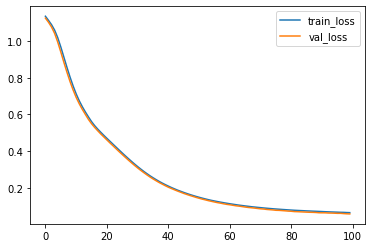

In [13]:
import matplotlib.pyplot as plt

e = np.arange(0, 100, 1)
plt.plot(e, train_loss_curve)
plt.plot(e, val_loss_curve)

plt.legend(['train_loss', 'val_loss'])
plt.show()

### accuracy curve

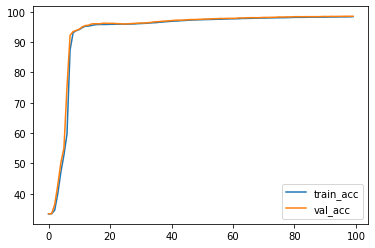

In [14]:
e = np.arange(0, 100, 1)
plt.plot(e, train_acc_curve)
plt.plot(e, val_acc_curve)

plt.legend(['train_acc', 'val_acc'])
plt.show()

### 최종 평가 - test set

In [15]:
y_true_list = []
y_pred_list = []

with torch.no_grad():
    model.eval()
    hidden_state = None

    test_losses = AverageMeter()
    test_accs = AverageMeter()
    
    for idx, (data, target) in enumerate(test_loader):
    
        data = data.permute(1,0,2).cuda()
        target = target.cuda()
        data = data.type(torch.cuda.FloatTensor)

        y_pred, hidden_state = model(data, hidden_state)

        test_loss = criterion(y_pred, target)
        test_losses.update(test_loss.item(), data.size(0)) 

        test_acc = Accuracy(y_pred, target)
        test_accs.update(test_acc[0].item(), data.size(0))

        stateful = False 
        if not stateful:
            hidden_state = None
        
        y_pred_label = torch.argmax(y_pred, dim=-1)
        #print(y_pred_label)
        
        y_pred_list[batch_size * idx : batch_size * (idx+1)] = y_pred_label
        y_true_list[batch_size * idx : batch_size * (idx+1)] = target
        
print('test accuracy : {:.2f}'.format(test_accs.avg))

#print(y_pred_list)
#print(y_true_list)

test accuracy : 98.30


In [16]:
for i in range(len(y_pred_list)):
    y_pred_list[i] = y_pred_list[i].item()
    y_true_list[i] = y_true_list[i].item()

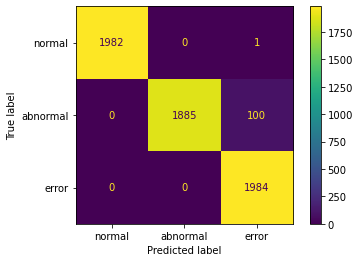

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

labels = ['normal', 'abnormal', 'error']
conf_mat = confusion_matrix(y_true_list, y_pred_list)
# print("Confusion matrix:\n", conf_mat)

display = ConfusionMatrixDisplay(conf_mat, display_labels=labels)
display.plot()

plt.show()
#labels = ['']